# jobs_clustering.ipynb

In [1]:
# ========================
# 1. Import Libraries
# ========================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score

In [2]:
# ========================
# 2. Load Data
# ========================
df = pd.read_csv("data/jobs_salaries_2023.csv")
print("Shape before dropna:", df.shape)
df.dropna(inplace=True)
print("Shape after dropna:", df.shape)

Shape before dropna: (1500, 11)
Shape after dropna: (1494, 11)


In [3]:
# ========================
# 3. Select Features for Clustering
# ========================
# You can adjust based on your goals
features = [
    "work_year",
    "experience_level",
    "employment_type",
    "job_title",
    "employee_residence",
    "remote_ratio",
    "company_location",
    "company_size",
    "salary_in_usd",
]

X = df[features]

# Separate categorical & numeric columns
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

In [4]:
# ========================
# 4. Preprocessing Pipeline
# ========================
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ]
)

In [5]:
# ========================
# 5. Dimensionality Reduction with TruncatedSVD
# ========================
# Keep only first 2 components for visualization
svd = TruncatedSVD(n_components=2, random_state=42)

# Full preprocessing + dimensionality reduction pipeline
pipeline_svd = Pipeline(steps=[("preprocess", preprocessor), ("svd", svd)])

X_reduced = pipeline_svd.fit_transform(X)

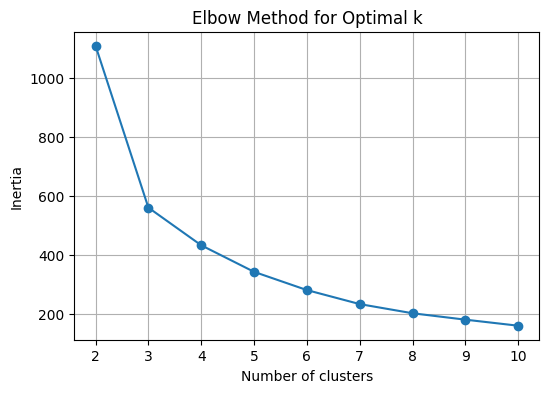

In [6]:
# ========================
# 6. Determine Optimal Clusters (Elbow Method)
# ========================
inertia_values = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_reduced)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_range, inertia_values, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

In [7]:
# ========================
# 7. Fit Final KMeans Model
# ========================
optimal_k = 4  # Choose based on elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_reduced)
df["Cluster"] = clusters

In [8]:
# ========================
# 8. Silhouette Score
# ========================
sil_score = silhouette_score(X_reduced, clusters)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.4521


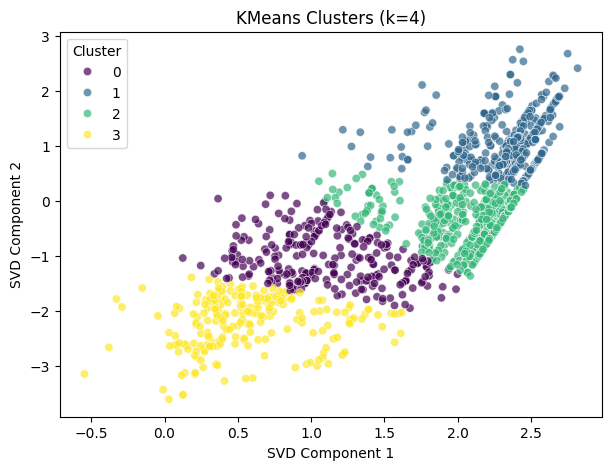

In [9]:
# ========================
# 9. Visualize Clusters
# ========================
plt.figure(figsize=(7, 5))
sns.scatterplot(
    x=X_reduced[:, 0], y=X_reduced[:, 1], hue=clusters, palette="viridis", alpha=0.7
)
plt.title(f"KMeans Clusters (k={optimal_k})")
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.legend(title="Cluster")
plt.show()

In [10]:
# ========================
# 10. Cluster Insights
# ========================
cluster_summary = df.groupby("Cluster").agg(
    {
        "salary_in_usd": ["mean", "median", "count"],
        "experience_level": lambda x: x.value_counts().index[0],
        "job_title": lambda x: x.value_counts().index[0],
        "remote_ratio": "mean",
    }
)

print("\n=== Cluster Summary ===")
print(cluster_summary)

# Save results
df.to_csv("jobs_salaries_with_clusters.csv", index=False)
print("Clustered dataset saved to jobs_salaries_with_clusters.csv")


=== Cluster Summary ===
         salary_in_usd                 experience_level       job_title  \
                  mean    median count         <lambda>        <lambda>   
Cluster                                                                   
0         97701.301471   86096.5   272               MI   Data Engineer   
1        184831.302752  180000.0   436               SE   Data Engineer   
2        136699.888087  135723.0   554               SE  Data Scientist   
3         54836.943966   50306.0   232               MI  Data Scientist   

        remote_ratio  
                mean  
Cluster               
0          68.933824  
1          17.087156  
2          74.909747  
3          75.862069  
Clustered dataset saved to jobs_salaries_with_clusters.csv
